## Aufgabe
1) Logistische Regression - Spamklassifikation
    - Führen Sie die Spamklassifikation der vorherigen Übung mit einer logistischen Regression durch.
    - Erstellen Sie für die Auswertung eine ROC-Kurve.
2) Klassifikation - SA-Subset
    - Selektieren Sie nur Reihen mit den 3 häufigsten Labels aus dem SA-Subset (df = df[df['labels'].isin([b'normal.', b'smurf.', b'neptune.'])].copy()).
    - Führen Sie eine Klassifikation dieser 3 Klassen durch und finden Sie den besten Parameter für min_freq.

### Notizen

#### Linear Regression
1) Lineare Kombination der Features
    - $z = w_{1}x_{1} + w_{2}x_{2} + \ldots + w_{n}x_{n} + b$
        - $w_{i}$: Gewichte
        - $x_{i}$: Featurewerte
        - $b$: Bias (auch $-\Theta$)
2) Anwendung der Sigmoid Funktion
    - $\hat{y}=\sigma(z)=\frac{1}{1+\mathscr{e}^{-z}}$
    - $\hat{y}$ ist die vorhergesagte wahrscheinlichkeit, dass das Sample 1 ist

#### Loss Function
...

Für Hyperparameter am besten die scores einzeln visualisieren um zu sehen, wann der Score optimal ist und wann er wieder abfällt

### Aufgaben

#### Imports

In [1165]:
from narwhals import Object
from sklearn.linear_model import LogisticRegression
import pandas as pd
import sklearn.metrics as skm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn import datasets
import sklearn.preprocessing as skp
import sklearn.model_selection as sms
import sklearn.compose
from sklearn.metrics import ConfusionMatrixDisplay

#### Aufgabe 1

##### Dataset

In [1166]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/AiDevNepal/ai-saturdays-workshop-8/master/data/spam.csv'
)
data

,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [1167]:
data['target'].value_counts()

target
ham     4825
spam     747
Name: count, dtype: int64

In [1168]:
data.describe()

,text,target
count,5572,5572
unique,5169,2
top,"Sorry, I'll call later",ham
freq,30,4825


Map ham/spam to 0/1 so i don't need custom scorers

In [1169]:
data['target'] = data['target'].map({'ham': 0, 'spam': 1})

In [1170]:
data.describe()

,target
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


##### Training

In [1171]:
min_df_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 25, 30, 40, 50]
threshold = 0.4
scores_precision = []
scores_recall = []
best_model = Object
best_model.fpr = None
best_model.tpr = None
best_model.thresholds = None
best_by = 'precision'

for min_df in min_df_values:
    countVectorizer = CountVectorizer(
        binary=True,
        stop_words='english',
        min_df=min_df,
        max_df=0.90
    )

    pipeline = Pipeline([
        ('vectorizer', countVectorizer),
        ('classifier', LogisticRegression())
    ])

    # stratify -> Verhältnis von spam/ham bleibt in etwa wie im gesamt-dataset
    X_train, X_test, y_train, y_test = train_test_split(
        data['text'],
        data['target'],
        test_size=0.15,
        random_state=42,
        stratify=data['target']
    )

    pipeline.fit(X_train, y_train)

    score_precision = skm.precision_score(pipeline.predict(X_test), y_test)
    score_recall = skm.recall_score(pipeline.predict(X_test), y_test)

    scores_precision.append(score_precision)
    scores_recall.append(score_recall)

    if best_by == 'precision' and (len(scores_precision) == 1 or scores_precision[len(scores_precision)-2] < score_precision):
        probabilities = pipeline.predict_proba(X_test)[:, 1]
        best_model.fpr, best_model.tpr, best_model.thresholds = roc_curve(y_test, probabilities)
    elif best_by == 'recall' and (len(scores_recall) == 1 or scores_recall[len(scores_recall)-2] < score_recall):
        probabilities = pipeline.predict_proba(X_test)[:, 1]
        best_model.fpr, best_model.tpr, best_model.thresholds = roc_curve(y_test, probabilities)
    elif best_by != 'precision' and best_by != 'recall':
        raise Exception('You need to either get the best model by precision- or recall-score.')


    # cross_val_score(estimator=pipeline, X=X_train, y=y_train, scoring='precision')

In [1172]:
scores_df = pd.DataFrame({
    'min_df': min_df_values,
    'scores_precision': scores_precision,
    'scores_recall': scores_recall
})

scores_melted = scores_df.melt(id_vars='min_df', var_name='Metric', value_name='Score')

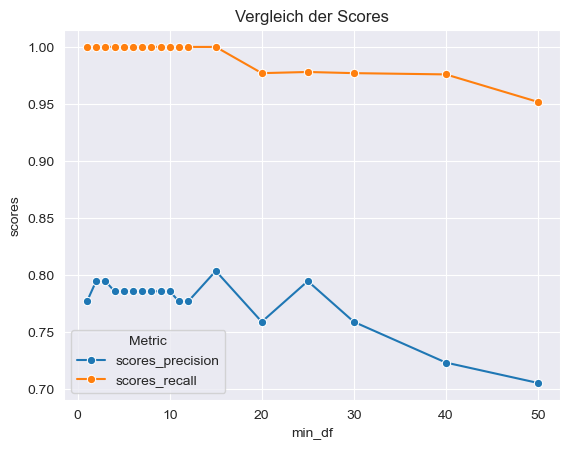

In [1173]:
plot = sns.lineplot(data=scores_melted, x='min_df', y='Score', hue='Metric', marker='o')

plot.set_title("Vergleich der Scores")
plt.xlabel('min_df')
plt.ylabel('scores')
plt.grid(True)
plt.show()

<Figure size 1200x800 with 0 Axes>

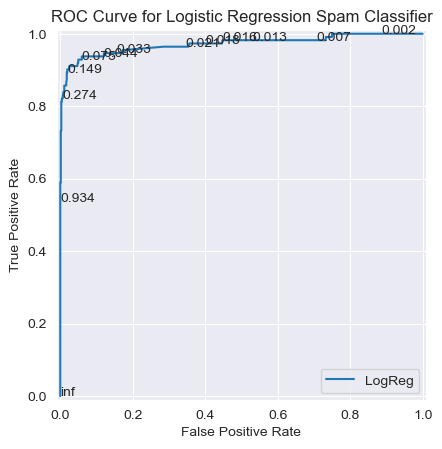

In [1174]:
# Plot the ROC Curve
plt.figure(figsize=(12, 8))
RocCurveDisplay(fpr=best_model.fpr, tpr=best_model.tpr, estimator_name='LogReg').plot()
for i in range(0, len(best_model.thresholds), 10):  # Nur jeden 10. Punkt beschriften
    plt.annotate(f'{best_model.thresholds[i]:.3f}', (best_model.fpr[i], best_model.tpr[i]))
plt.title('ROC Curve for Logistic Regression Spam Classifier')
plt.grid(True)
plt.show()

##### Wes zeigt die ROC-Kurve?
> Reciever Operating Characteristic Curves (ROC-Kurven), stellen die *True Positive Rate* (TPR) gegen die *False Positive Rate* (FPR) bei variierenden Thresholds dar.

#### Aufgabe 2

In [1175]:
dataset = datasets.fetch_kddcup99(subset='SA', as_frame=True)
dataset

{'data':        duration protocol_type     service   flag src_bytes dst_bytes land  \
 0             0        b'tcp'     b'http'  b'SF'       181      5450    0   
 1             0        b'tcp'     b'http'  b'SF'       239       486    0   
 2             0        b'tcp'     b'http'  b'SF'       235      1337    0   
 3             0        b'tcp'     b'http'  b'SF'       219      1337    0   
 4             0        b'tcp'     b'http'  b'SF'       217      2032    0   
 ...         ...           ...         ...    ...       ...       ...  ...   
 100650        0        b'tcp'   b'kshell'  b'S0'         0         0    0   
 100651        0       b'icmp'    b'ecr_i'  b'SF'       520         0    0   
 100652        0       b'icmp'    b'ecr_i'  b'SF'      1032         0    0   
 100653        0       b'icmp'    b'ecr_i'  b'SF'      1032         0    0   
 100654        0        b'tcp'  b'private'  b'S0'         0         0    0   
 
        wrong_fragment urgent hot  ... dst_host_count 

In [1176]:
dataset['target'].value_counts()

labels
b'normal.'          97278
b'smurf.'            2385
b'neptune.'           926
b'back.'               19
b'portsweep.'          13
b'ipsweep.'            10
b'teardrop.'            8
b'satan.'               8
b'warezclient.'         5
b'nmap.'                2
b'guess_passwd.'        1
Name: count, dtype: int64

In [1177]:
df = dataset['frame']
df = df = df[df['labels'].isin([b'normal.', b'smurf.', b'neptune.'])].copy()
df.describe()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
count,100589,100589,100589,100589,100589,100589,100589,100589,100589,100589,...,100589,100589.0,100589.0,100589.0,100589.0,100589.0,100589.0,100589.0,100589.0,100589
unique,2353,3,51,9,3248,10687,2,1,2,19,...,256,101.0,99.0,101.0,56.0,93.0,56.0,101.0,101.0,3
top,0,b'tcp',b'http',b'SF',105,0,0,0,0,0,...,255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'normal.'
freq,88899,77739,61886,94094,7370,17506,100588,100589,100588,100047,...,57496,65201.0,64404.0,33740.0,50618.0,94982.0,94425.0,91117.0,91195.0,97278


In [1178]:
# Disclaimer: Dieser Block wurde mit ChatGPT generiert und durch mich angepasst
# Downsample "normal."
normal_df = df[df['labels'] == b'normal.'].sample(n=1000, random_state=42)
smurf_df = df[df['labels'] == b'smurf.']
neptune_df = df[df['labels'] == b'neptune.']

# Combine into new balanced dataframe
df = pd.concat([normal_df, smurf_df, neptune_df]).sample(frac=1, random_state=42).reset_index(drop=True)

In [1179]:
df['labels'].value_counts()

labels
b'smurf.'      2385
b'normal.'     1000
b'neptune.'     926
Name: count, dtype: int64

In [1180]:
df['protocol_type'].value_counts()

protocol_type
b'icmp'    2402
b'tcp'     1724
b'udp'      185
Name: count, dtype: int64

Get how many classes occure below min_freq times.

In [1181]:
features = dataset['feature_names']
min_freq = 10
low_freq_counts = []

for feature in features:
    counts = df[feature].value_counts()
    low_freq = counts[counts < min_freq]
    low_freq_counts.append(len(low_freq))

features

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

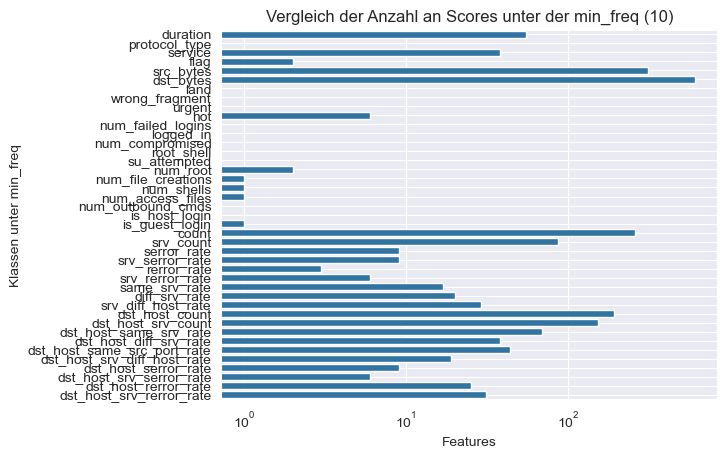

<Figure size 1000x1000 with 0 Axes>

In [1182]:
low_freq_df = pd.DataFrame({
    'Features': features,
    'Values': low_freq_counts
})

plot = sns.barplot(data=low_freq_df, x='Values', y='Features')
plot.set_xscale('log')

plot.set_title("Vergleich der Anzahl an Scores unter der min_freq ("+str(min_freq)+")")
plt.xlabel('Features')
plt.ylabel('Klassen unter min_freq')
plt.grid(True)
plt.figure(figsize=(10, 10))
plt.show()

In [1183]:
# cleanup
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass  # Leave as object (likely categorical)

In [1184]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,4311.000000,4.311000e+03,4311.000000,4311.0,4311.0,4311.0,4311.000000,4311.0,4311.000000,4311.0,...,4311.000000,4311.000000,4311.000000,4311.000000,4311.000000,4311.000000,4311.000000,4311.000000,4311.000000,4311.000000
mean,43.923220,1.178211e+03,979.518441,0.0,0.0,0.0,0.011598,0.0,0.167711,0.0,...,229.312688,190.532591,0.761696,0.025857,0.585829,0.005614,0.172932,0.172814,0.056729,0.055941
std,565.260725,3.347152e+04,9273.840279,0.0,0.0,0.0,0.384569,0.0,0.373652,0.0,...,68.651101,104.764656,0.406140,0.088642,0.483441,0.022470,0.377787,0.377773,0.229228,0.227486
min,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.050000e+02,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,255.000000,75.000000,0.620000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,255.000000,255.000000,1.000000,0.030000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15294.000000,2.194619e+06,359105.000000,0.0,0.0,0.0,19.000000,0.0,1.000000,0.0,...,255.000000,255.000000,1.000000,0.910000,1.000000,0.350000,1.000000,1.000000,1.000000,1.000000


In [1185]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,b'icmp',b'ecr_i',b'SF',1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,b'smurf.'
1,0,b'icmp',b'ecr_i',b'SF',1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,b'smurf.'
2,0,b'tcp',b'private',b'REJ',0,0,0,0,0,0,...,8,0.03,0.07,0.00,0.00,0.0,0.0,1.0,1.0,b'neptune.'
3,0,b'tcp',b'domain',b'S0',0,0,0,0,0,0,...,6,0.02,0.08,0.00,0.00,1.0,1.0,0.0,0.0,b'neptune.'
4,0,b'icmp',b'ecr_i',b'SF',1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,b'smurf.'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4306,0,b'tcp',b'private',b'REJ',0,0,0,0,0,0,...,20,0.08,0.07,0.00,0.00,0.0,0.0,1.0,1.0,b'neptune.'
4307,0,b'tcp',b'http',b'SF',349,1262,0,0,0,0,...,255,1.00,0.00,0.02,0.02,0.0,0.0,0.0,0.0,b'normal.'
4308,0,b'icmp',b'ecr_i',b'SF',520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,b'smurf.'
4309,0,b'tcp',b'private',b'REJ',0,0,0,0,0,0,...,19,0.07,0.07,0.00,0.00,0.0,0.0,1.0,1.0,b'neptune.'


In [1186]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.decode('utf-8').astype('category')

In [1187]:
df.describe(include=['category'])

,protocol_type,service,flag,labels
count,4311,4311,4311,4311
unique,3,45,5,3
top,icmp,ecr_i,SF,smurf.
freq,2402,2393,3324,2385


##### Feature Engineering

*OneHot Encoding*

Da wir bei der Multiclass LR nichts mit den labels in Stringform anfangen können übersetzen wir diese in Vektoren.


In [1188]:
train_df, test_df = sms.train_test_split(df, random_state=42)

In [1189]:
ohot = skp.OneHotEncoder(
    sparse_output=False,
    handle_unknown='infrequent_if_exist',
    min_frequency=min_freq,
)

In [1190]:
for col in df.select_dtypes('category').columns:
    print(df[[col]].value_counts(), end='\n\n')

protocol_type
icmp             2402
tcp              1724
udp               185
Name: count, dtype: int64

service   
ecr_i         2393
private        942
http           655
smtp            83
domain_u        59
other           52
ftp_data        48
telnet           7
finger           7
eco_i            6
ftp              5
ntp_u            4
auth             4
urp_i            3
domain           3
shell            3
klogin           3
mtp              2
daytime          2
bgp              2
http_443         2
kshell           2
sql_net          2
IRC              1
ssh              1
sunrpc           1
supdup           1
systat           1
time             1
uucp_path        1
remote_job       1
ldap             1
printer          1
nntp             1
netstat          1
netbios_ns       1
link             1
Z39_50           1
iso_tsap         1
imap4            1
exec             1
efs              1
echo             1
courier          1
vmnet            1
Name: count, dtype: int64



In [1191]:
oh_protocol = ohot.fit_transform(train_df[['protocol_type']])
oh_protocol

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [1192]:
oh_protocol = ohot.fit_transform(train_df[['service']])
oh_protocol

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [1193]:
oh_protocol = ohot.fit_transform(train_df[['flag']])
oh_protocol

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

##### Pipelining Feature Processing

In [1194]:
min_freqs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 25, 30, 40, 50, 100]
preprocessors = []

feature_names = dataset.feature_names[:]

categorical_cols = df.select_dtypes(include=['category']).columns.tolist()
categorical_cols.remove('labels') # remove target col
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

for min_freq in min_freqs:
    ohot = skp.OneHotEncoder(
            sparse_output=False,
            handle_unknown='infrequent_if_exist',
            min_frequency=min_freq,
    )
    preprocessor = sklearn.compose.ColumnTransformer(
        transformers=[
            ('numerical', skp.StandardScaler(), numerical_cols),
            ('onehot', ohot, categorical_cols),
        ]
    )
    preprocessors.append(preprocessor)

preprocessors[2]

ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                 ['duration', 'src_bytes', 'dst_bytes', 'land',
                                  'wrong_fragment', 'urgent', 'hot',
                                  'num_failed_logins', 'logged_in',
                                  'num_compromised', 'root_shell',
                                  'su_attempted', 'num_root',
                                  'num_file_creations', 'num_shells',
                                  'num_access_files', 'num_outbound_cmds',
                                  'is_host_login', 'is_guest_login', 'count',
                                  'srv_count', 'serror_rate', 'srv_serror_rate',
                                  'rerror_rate', 'srv_rerror_rate',
                                  'same_srv_rate', 'diff_srv_rate',
                                  'srv_diff_host_rate', 'dst_host_count',
                                  'dst_host_srv_count', ...]),
                                ('onehot',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                               min_frequency=3,
                                               sparse_output=False),
                                 ['protocol_type', 'service', 'flag'])])

##### Intrusion Classification

In [1195]:
log_reg = LogisticRegression()
log_reg

LogisticRegression()

In [1196]:
models = []

for preprocessor in preprocessors:
    models.append(
        Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', log_reg),
        ])
    )

models[1]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes', 'land',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'logged_in',
                                                   'num_compromised',
                                                   'root_shell', 'su_attempted',
                                                   'num_root',
                                                   'num_file_creations',
                                                   'num_shells',
                                                   'num_access_files',
                                                   'num_outbound_cmds',
                                                   'is_host_login',
                                                   'is...t',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                                                   'rerror_rate',
                                                   'srv_rerror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count', ...]),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=2,
                                                                sparse_output=False),
                                                  ['protocol_type', 'service',
                                                   'flag'])])),
                ('classifier', LogisticRegression())])

In [1197]:
# Nochmal die Split-DataFrames überschreiben, um keine Änderungen an den Daten zu übernehmen
train_df, test_df = sms.train_test_split(df, random_state=42)
classification_reports = []
y_true_trains = []
y_pred_trains = []
y_true_tests = []
y_pred_tests = []

for model in models:
    model.fit(
        X = train_df[feature_names],
        y = train_df['labels']
    )

    y_true_train = train_df['labels']
    y_true_trains.append(y_true_train)
    y_pred_train = model.predict(train_df[feature_names])
    y_pred_trains.append(y_pred_train)

    y_true_test = test_df['labels']
    y_true_tests.append(y_true_test)
    y_pred_test = model.predict(test_df[feature_names])
    y_pred_tests.append(y_pred_test)

    classification_reports.append(skm.classification_report(y_true_test, y_pred_test))

##### Evaluation

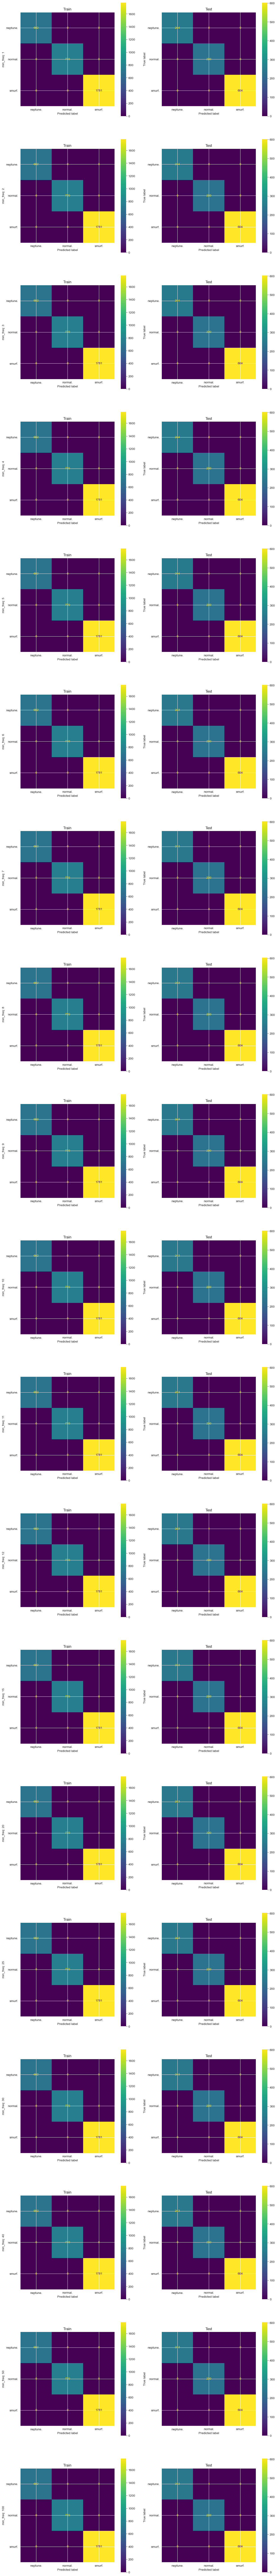

In [1205]:
fig, axes = plt.subplots(len(min_freqs), 2, figsize=(15, 150))

for i in range(len(min_freqs)):
    _ = ConfusionMatrixDisplay.from_predictions(y_true_trains[i], y_pred_trains[i], ax=axes[i][0])
    axes[i][0].set_title('Train')

    _ = ConfusionMatrixDisplay.from_predictions(y_true_tests[i], y_pred_tests[i], ax=axes[i][1])
    axes[i][1].set_title('Test')

    axes[i, 0].set_ylabel('min_freq: ' + str(min_freqs[i]))

In [1162]:
for report in classification_reports:
    print(report)
    print('\n----------------------------------------------------------\n')

              precision    recall  f1-score   support

    neptune.       1.00      1.00      1.00       241
     normal.       1.00      1.00      1.00       212
      smurf.       1.00      1.00      1.00       626

    accuracy                           1.00      1079
   macro avg       1.00      1.00      1.00      1079
weighted avg       1.00      1.00      1.00      1079


----------------------------------------------------------

              precision    recall  f1-score   support

    neptune.       1.00      1.00      1.00       241
     normal.       1.00      1.00      1.00       212
      smurf.       1.00      1.00      1.00       626

    accuracy                           1.00      1079
   macro avg       1.00      1.00      1.00      1079
weighted avg       1.00      1.00      1.00      1079


----------------------------------------------------------

              precision    recall  f1-score   support

    neptune.       1.00      1.00      1.00       241
     no